<center>
##IFT 6135 : Representation Learning 
##Winter 2018
  
# ASSIGNMENT - 2 : PROGRAMMING PART
# Problem (5.1) :  Detailed evaluation of trained models - Per-timestep Loss




Submitted by 

___________________________________________________



## PRAVISH SAINATH
####20125633
####M.Sc. Informatique
####Université de Montréal


In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
DRIVE_PATH = 'drive/My Drive/DL/HW-2/experiments'
%cd 'drive/My Drive/DL/HW-2/experiments'

In [41]:
!ls

Archived  best	data  GRU  IFT6135-HW2-Results	models.py  ptb-lm.py  RNN  TF


In [0]:
import torch
import torch.nn as nn

import numpy as np
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable

import argparse
import time
import collections
import os
import sys

## Models

In [0]:
def clones(module, N):
    """
    A helper function for producing N identical layers (each with their own parameters).

    inputs:
        module: a pytorch nn.module
        N (int): the number of copies of that module to return

    returns:
        a ModuleList with the copies of the module (the ModuleList is itself also a module)
    """
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

### RNN 

In [0]:
class RNN(nn.Module): # Implement a stacked vanilla RNN with Tanh nonlinearities.
  def __init__(self, emb_size, hidden_size, seq_len, batch_size, vocab_size, num_layers, dp_keep_prob):
    """
    emb_size:     The number of units in the input embeddings
    hidden_size:  The number of hidden units per layer
    seq_len:      The length of the input sequences
    vocab_size:   The number of tokens in the vocabulary (10,000 for Penn TreeBank)
    num_layers:   The depth of the stack (i.e. the number of hidden layers at
                  each time-step)
    dp_keep_prob: The probability of *not* dropping out units in the
                  non-recurrent connections.
                  Do not apply dropout on recurrent connections.
    """
    super(RNN, self).__init__()

    # TODO ========================
    # Initialization of the parameters of the recurrent and fc layers.
    # Your implementation should support any number of stacked hidden layers
    # (specified by num_layers), use an input embedding layer, and include fully
    # connected layers with dropout after each recurrent layer.
    # Note: you may use pytorch's nn.Linear, nn.Dropout, and nn.Embedding
    # modules, but not recurrent modules.
    #
    # To create a variable number of parameter tensors and/or nn.Modules
    # (for the stacked hidden layer), you may need to use nn.ModuleList or the
    # provided clones function (as opposed to a regular python list), in order
    # for Pytorch to recognize these parameters as belonging to this nn.Module
    # and compute their gradients automatically. You're not obligated to use the
    # provided clones function.


    self.emb_size = emb_size
    self.hidden_size = hidden_size
    self.seq_len = seq_len
    self.batch_size = batch_size
    self.vocab_size = vocab_size
    self.num_layers = num_layers

    self.embedding = nn.Embedding(self.vocab_size, self.emb_size)

    self.W_x = clones(nn.Linear(self.hidden_size,self.hidden_size, bias=False),self.num_layers-1)
    self.W_x.insert(0,nn.Linear(self.emb_size,self.hidden_size, bias=False))

    self.W_h = clones(nn.Linear(self.hidden_size,self.hidden_size),self.num_layers)
    self.W_y = nn.Linear(self.hidden_size,self.vocab_size)

    self.dropout = nn.Dropout(p=1-dp_keep_prob)

    self.init_weights()

  def init_weights(self):

    # Initialize the embedding and output weights uniformly in the range [-0.1, 0.1]
    # and output biases to 0 (in place). The embeddings should not use a bias vector.
    # Initialize all other (i.e. recurrent and linear) weights AND biases uniformly
    # in the range [-k, k] where k is the square root of 1/hidden_size

    nn.init.uniform_(self.embedding.weight.data, -0.1, 0.1)

    nn.init.uniform_(self.W_y.weight,-0.1, 0.1)
    self.W_y.bias.data.fill_(0.0)

    k = 1 / np.sqrt(self.hidden_size)

    for w_x in self.W_x:
        nn.init.uniform_(w_x.weight,-k,k)

    for w_h in self.W_h:
        nn.init.uniform_(w_h.weight,-k,k)
        nn.init.uniform_(w_h.bias,-k,k)


  def init_hidden(self):
    # initialize the hidden states to zero
    """
    This is used for the first mini-batch in an epoch, only.
    """
    # a parameter tensor of shape (self.num_layers, self.batch_size, self.hidden_size)
    return torch.zeros(self.num_layers, self.batch_size, self.hidden_size)


  def forward(self, inputs, hidden):
    # Compute the forward pass, using nested python for loops.
    # The outer for loop should iterate over timesteps, and the
    # inner for loop should iterate over hidden layers of the stack.
    #
    # Within these for loops, use the parameter tensors and/or nn.modules you
    # created in __init__ to compute the recurrent updates according to the
    # equations provided in the .tex of the assignment.
    #
    # Note that those equations are for a single hidden-layer RNN, not a stacked
    # RNN. For a stacked RNN, the hidden states of the l-th layer are used as
    # inputs to to the {l+1}-st layer (taking the place of the input sequence).

    """
    Arguments:
        - inputs: A mini-batch of input sequences, composed of integers that
                    represent the index of the current token(s) in the vocabulary.
                        shape: (seq_len, batch_size)
        - hidden: The initial hidden states for every layer of the stacked RNN.
                        shape: (num_layers, batch_size, hidden_size)

    Returns:
        - Logits for the softmax over output tokens at every time-step.
              **Do NOT apply softmax to the outputs!**
              Pytorch's CrossEntropyLoss function (applied in ptb-lm.py) does
              this computation implicitly.
                    shape: (seq_len, batch_size, vocab_size)
        - The final hidden states for every layer of the stacked RNN.
              These will be used as the initial hidden states for all the
              mini-batches in an epoch, except for the first, where the return
              value of self.init_hidden will be used.
              See the repackage_hiddens function in ptb-lm.py for more details,
              if you are curious.
                    shape: (num_layers, batch_size, hidden_size)
    """
    inputs = self.embedding(inputs)
    output_sequence_logits = []

    for t in range(self.seq_len):
        next_hidden = []
        for layer in range(self.num_layers):
            dropped_out_x = self.dropout(inputs[t] if layer == 0 else next_hidden[layer-1])
            next_hidden_value = torch.tanh(self.W_x[layer](dropped_out_x) + self.W_h[layer](hidden[layer]))
            next_hidden.append(next_hidden_value)
        dropped_out_last_hidden = self.dropout(next_hidden[layer])
        output_logit = self.W_y(dropped_out_last_hidden)
        output_sequence_logits.append(output_logit)
        hidden = torch.stack(next_hidden)
    logits = torch.stack(output_sequence_logits)
    return logits.view(self.seq_len, self.batch_size, self.vocab_size), hidden

### GRU

In [0]:
class GRU(nn.Module):  # Implement a stacked GRU RNN
    """
        Follow the same instructions as for RNN (above), but use the equations for
        GRU, not Vanilla RNN.
        """

    def __init__(self, emb_size, hidden_size, seq_len, batch_size, vocab_size, num_layers, dp_keep_prob):
        super(GRU, self).__init__()

        self.emb_size = emb_size
        self.hidden_size = hidden_size
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.vocab_size = vocab_size
        self.num_layers = num_layers
        self.dp_keep_prob = dp_keep_prob


        # using the notation for U,W,h... as given in the assignment 2 equation
        self.Ur = clones(nn.Linear(self.hidden_size, self.hidden_size), self.num_layers)


        self.Uz = clones(nn.Linear(self.hidden_size, self.hidden_size), self.num_layers)

        self.Uh = clones(nn.Linear(self.hidden_size, self.hidden_size), self.num_layers)

        # W will have to deal with 1.input dim, then 2.later inputs from previous layers
        self.Wr = clones(nn.Linear(self.hidden_size, self.hidden_size), self.num_layers-1)
        self.Wr.insert(0, nn.Linear(self.emb_size, self.hidden_size, bias=False))

        self.Wz = clones(nn.Linear(self.hidden_size, self.hidden_size), self.num_layers-1)
        self.Wz.insert(0, nn.Linear(self.emb_size, self.hidden_size, bias=False))

        self.Wh = clones(nn.Linear(self.hidden_size, self.hidden_size), self.num_layers-1)
        self.Wh.insert(0, nn.Linear(self.emb_size, self.hidden_size, bias=False))

        self.W_Output = nn.Linear(self.hidden_size,self.vocab_size)


        self.dropout_layers = nn.Dropout(1-self.dp_keep_prob)
            #[nn.Dropout(1 - self.dp_keep_prob) for _ in range(self.num_layers)]

        self.embedding = nn.Embedding(self.vocab_size, self.emb_size)

        self.init_weights_uniform()


# self.fc_layer_with_dropout.apply(self.init_weights_uniform_FC)

    def init_weights_uniform(self):
        nn.init.uniform_(self.embedding.weight.data, -0.1, 0.1)

        k = 1 / np.sqrt(self.hidden_size)

        for w_r in self.Wr:
            nn.init.uniform_(w_r.weight, -k, k)

        for w_z in self.Wz:
            nn.init.uniform_(w_z.weight, -k, k)

        for w_h in self.Wh:
            nn.init.uniform_(w_h.weight, -k, k)



        for u_r in self.Ur:
            nn.init.uniform_(u_r.weight, -k, k)
            nn.init.uniform_(u_r.bias, -k, k)

        for u_z in self.Uz:
            nn.init.uniform_(u_z.weight, -k, k)
            nn.init.uniform_(u_z.bias, -k, k)

        for u_h in self.Uh:
            nn.init.uniform_(u_h.weight, -k, k)
            nn.init.uniform_(u_h.bias, -k, k)



        nn.init.uniform_(self.W_Output.weight, -0.1, 0.1)
        self.W_Output.bias.data.fill_(0.0)
        return


    def init_weights_uniform_FC(self, m):
        if type(m) == nn.Linear:
            torch.nn.init.uniform_(m.weight, -0.1, 0.1)
            m.bias.data.fill_(0)
        return


    def init_hidden(self):
        return torch.zeros(self.num_layers, self.batch_size, self.hidden_size)


    # a parameter tensor of shape (self.num_layers, self.batch_size, self.hidden_size)

    def layer_calculation_gru(self, x, hidden, layer):
        x = self.dropout_layers(x)

        r_pre =  self.Wr[layer](x) +  self.Ur[layer](hidden[layer])
        r = torch.sigmoid(r_pre)

        z_pre = self.Wz[layer](x) + self.Uz[layer](hidden[layer])
        z = torch.sigmoid(z_pre)

        r_hidden_layer_element_product= (r * hidden[layer])
        h_tilda_pre = self.Wh[layer](x) + self.Uh[layer](r_hidden_layer_element_product)
        h_tilda = torch.tanh(h_tilda_pre)

        # one_minus_z = torch.ones(z.size()).to(device) - z
        one_minus_z = 1 - z
        h = (one_minus_z * hidden[layer]) + (z * h_tilda)

        return h


    def forward(self, inputs, hidden):

        inputs = self.embedding(inputs)
        final_output_list = []
        for time_in in range(self.seq_len):
            current_input = inputs[time_in]
            hidden_states = []
            for layer in range(self.num_layers):
                if layer == 0:
                    layer_output = self.layer_calculation_gru(current_input, hidden, layer)
                else:
                    layer_output = self.layer_calculation_gru(hidden_states[layer - 1], hidden, layer)

                hidden_states.append(layer_output)
            last_hidden_dropout= self.dropout_layers(hidden_states[layer])
            final_output_list.append(self.W_Output(last_hidden_dropout))
            hidden = torch.stack(hidden_states)

        return torch.stack(final_output_list), hidden


### TRANSFORMER

In [0]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, n_heads, n_units, dropout=0.1):
        """
        n_heads: the number of attention heads
        n_units: the number of output units
        dropout: probability of DROPPING units
        """
        super(MultiHeadedAttention, self).__init__()
        # This sets the size of the keys, values, and queries (self.d_k) to all
        # be equal to the number of output units divided by the number of heads.
        self.d_k = n_units // n_heads
        # This requires the number of n_heads to evenly divide n_units.
        assert n_units % n_heads == 0
        self.n_units = n_units

        # TODO: create/initialize any necessary parameters or layers
        # Initialize all weights and biases uniformly in the range [-k, k],
        # where k is the square root of 1/n_units.
        # Note: the only Pytorch modules you are allowed to use are nn.Linear
        # and nn.Dropout

        self.n_heads = n_heads
        
        ## Parallel attention heads for faster run
        self.weights_Q = nn.Linear(self.n_units, self.n_units)
        self.weights_K = nn.Linear(self.n_units, self.n_units)
        self.weights_V = nn.Linear(self.n_units, self.n_units)

        self.weights_O = nn.Linear(self.n_units, self.n_units)

        k = 1/np.sqrt(self.n_units)

        nn.init.uniform_(self.weights_O.weight,-k,k)
        nn.init.uniform_(self.weights_O.bias,-k,k)

        nn.init.uniform_(self.weights_Q.weight,-k,k)
        nn.init.uniform_(self.weights_Q.bias,-k,k)

        nn.init.uniform_(self.weights_K.weight,-k,k)
        nn.init.uniform_(self.weights_K.bias,-k,k)

        nn.init.uniform_(self.weights_V.weight,-k,k)
        nn.init.uniform_(self.weights_V.bias,-k,k)

        self.dropout = nn.Dropout(p=dropout)


    def forward(self, query, key, value, mask=None):
        # TODO: implement the masked multi-head attention.
        # query, key, and value all have size: (batch_size, seq_len, self.n_units)
        # mask has size: (batch_size, seq_len, seq_len)
        # As described in the .tex, apply input masking to the softmax
        # generating the "attention values" (i.e. A_i in the .tex)
        # Also apply dropout to the attention values.

        batch_size = query.size(0)

        # Linear projections of Q, K, V concatenated for all heads
        QW_Q = self.weights_Q(query).view(batch_size, -1, self.n_heads, self.d_k)
        KW_K = self.weights_K(key).view(batch_size, -1, self.n_heads, self.d_k)
        VW_V = self.weights_V(value).view(batch_size, -1, self.n_heads, self.d_k)

        QW_Q = QW_Q.transpose(1, 2)
        KW_K = KW_K.transpose(1, 2)
        VW_V = VW_V.transpose(1, 2)

        H = self.compute_attention(QW_Q, KW_K, VW_V, mask)

        concatenated_H = H.transpose(1, 2).contiguous().view(batch_size, -1, self.n_heads * self.d_k)

        output_attention = self.weights_O(concatenated_H)

        return output_attention # size: (batch_size, seq_len, self.n_units)


    def compute_attention(self, QW_Q, KW_K, VW_V, mask):

        scores = torch.matmul(QW_Q, KW_K.transpose(-2, -1)) / np.sqrt(self.d_k)

        if mask is not None:
            # Extending the mask by repeating the mask for each of the heads
            mask = mask.unsqueeze(1)
            scores = scores.masked_fill(mask == 0, -1e9)

        attention = F.softmax(scores, dim = -1)

        attention = self.dropout(attention)

        output = torch.matmul(attention, VW_V)

        return output

In [0]:
# The encodings of elements of the input sequence

class WordEmbedding(nn.Module):
    def __init__(self, n_units, vocab):
        super(WordEmbedding, self).__init__()
        self.lut = nn.Embedding(vocab, n_units)
        self.n_units = n_units

    def forward(self, x):
        #print (x)
        return self.lut(x) * math.sqrt(self.n_units)


class PositionalEncoding(nn.Module):
    def __init__(self, n_units, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, n_units)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, n_units, 2).float() *
                             -(math.log(10000.0) / n_units))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)],
                         requires_grad=False)
        return self.dropout(x)

In [0]:
# The TransformerBlock and the full Transformer


class TransformerBlock(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(TransformerBlock, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(ResidualSkipConnectionWithLayerNorm(size, dropout), 2)

    def forward(self, x, mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask)) # apply the self-attention
        return self.sublayer[1](x, self.feed_forward) # apply the position-wise MLP


class TransformerStack(nn.Module):
    """
    This will be called on the TransformerBlock (above) to create a stack.
    """
    def __init__(self, layer, n_blocks): # layer will be TransformerBlock (below)
        super(TransformerStack, self).__init__()
        self.layers = clones(layer, n_blocks)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)


class FullTransformer(nn.Module):
    def __init__(self, transformer_stack, embedding, n_units, vocab_size):
        super(FullTransformer, self).__init__()
        self.transformer_stack = transformer_stack
        self.embedding = embedding
        self.output_layer = nn.Linear(n_units, vocab_size)

    def forward(self, input_sequence, mask):
        embeddings = self.embedding(input_sequence)
        return F.log_softmax(self.output_layer(self.transformer_stack(embeddings, mask)), dim=-1)


def make_model(vocab_size, n_blocks=6,
               n_units=512, n_heads=16, dropout=0.1):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(n_heads, n_units)
    ff = MLP(n_units, dropout)
    position = PositionalEncoding(n_units, dropout)
    model = FullTransformer(
        transformer_stack=TransformerStack(TransformerBlock(n_units, c(attn), c(ff), dropout), n_blocks),
        embedding=nn.Sequential(WordEmbedding(n_units, vocab_size), c(position)),
        n_units=n_units,
        vocab_size=vocab_size
        )

    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

In [0]:
TRANSFORMER = make_model 

In [0]:
#----------------------------------------------------------------------------------
# Data processing

def subsequent_mask(size):
    """ helper function for creating the masks. """
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

class Batch:
    "Object for holding a batch of data with mask during training."
    def __init__(self, x, pad=0):
        self.data = x
        self.mask = self.make_mask(self.data, pad)

    @staticmethod
    def make_mask(data, pad):
        "Create a mask to hide future words."
        mask = (data != pad).unsqueeze(-2)
        mask = mask & Variable(
            subsequent_mask(data.size(-1)).type_as(mask.data))
        return mask

In [0]:
#----------------------------------------------------------------------------------
# Some standard modules

class LayerNorm(nn.Module):
    "layer normalization, as in: https://arxiv.org/abs/1607.06450"
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2


class ResidualSkipConnectionWithLayerNorm(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(ResidualSkipConnectionWithLayerNorm, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))


class MLP(nn.Module):
    """
    This is just an MLP with 1 hidden layer
    """
    def __init__(self, n_units, dropout=0.1):
        super(MLP, self).__init__()
        self.w_1 = nn.Linear(n_units, 2048)
        self.w_2 = nn.Linear(2048, n_units)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

## Data Loading

In [0]:
# HELPER FUNCTIONS
def _read_words(filename):
    with open(filename, "r") as f:
      return f.read().replace("\n", "<eos>").split()

def _build_vocab(filename):
    data = _read_words(filename)

    counter = collections.Counter(data)
    count_pairs = sorted(counter.items(), key=lambda x: (-x[1], x[0]))

    words, _ = list(zip(*count_pairs))
    word_to_id = dict(zip(words, range(len(words))))
    id_to_word = dict((v, k) for k, v in word_to_id.items())

    return word_to_id, id_to_word

def _file_to_word_ids(filename, word_to_id):
    data = _read_words(filename)
    return [word_to_id[word] for word in data if word in word_to_id]

# Processes the raw data from text files
def ptb_raw_data(data_path=None, prefix="ptb"):
    train_path = os.path.join(data_path, prefix + ".train.txt")
    valid_path = os.path.join(data_path, prefix + ".valid.txt")
    test_path = os.path.join(data_path, prefix + ".test.txt")

    word_to_id, id_2_word = _build_vocab(train_path)
    train_data = _file_to_word_ids(train_path, word_to_id)
    valid_data = _file_to_word_ids(valid_path, word_to_id)
    test_data = _file_to_word_ids(test_path, word_to_id)
    return train_data, valid_data, test_data, word_to_id, id_2_word

# Yields minibatches of data
def ptb_iterator(raw_data, batch_size, num_steps):
    raw_data = np.array(raw_data, dtype=np.int32)

    data_len = len(raw_data)
    batch_len = data_len // batch_size
    data = np.zeros([batch_size, batch_len], dtype=np.int32)
    for i in range(batch_size):
        data[i] = raw_data[batch_len * i:batch_len * (i + 1)]

    epoch_size = (batch_len - 1) // num_steps

    if epoch_size == 0:
        raise ValueError("epoch_size == 0, decrease batch_size or num_steps")

    for i in range(epoch_size):
        x = data[:, i*num_steps:(i+1)*num_steps]
        y = data[:, i*num_steps+1:(i+1)*num_steps+1]
        yield (x, y)


In [0]:
class Batch:
    "Data processing for the transformer. This class adds a mask to the data."
    def __init__(self, x, pad=-1):
        self.data = x
        self.mask = self.make_mask(self.data, pad)

    @staticmethod
    def make_mask(data, pad):
        "Create a mask to hide future words."

        def subsequent_mask(size):
            """ helper function for creating the masks. """
            attn_shape = (1, size, size)
            subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
            return torch.from_numpy(subsequent_mask) == 0

        mask = (data != pad).unsqueeze(-2)
        mask = mask & Variable(
            subsequent_mask(data.size(-1)).type_as(mask.data))
        return mask

In [54]:
print('Loading data from ./data')
raw_data = ptb_raw_data(data_path='data')
train_data, valid_data, test_data, word_to_id, id_2_word = raw_data
vocab_size = len(word_to_id)
print('  vocabulary size: {}'.format(vocab_size))

Loading data from ./data
  vocabulary size: 10000


In [0]:
# LOSS FUNCTION
loss_fn = nn.CrossEntropyLoss()

In [0]:
torch.manual_seed(1111)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [0]:
###############################################################################
#
# DEFINE COMPUTATIONS FOR PROCESSING ONE EPOCH
#
###############################################################################

def repackage_hidden(h):
    """
    Wraps hidden states in new Tensors, to detach them from their history.

    This prevents Pytorch from trying to backpropagate into previous input
    sequences when we use the final hidden states from one mini-batch as the
    initial hidden states for the next mini-batch.

    Using the final hidden states in this way makes sense when the elements of
    the mini-batches are actually successive subsequences in a set of longer sequences.
    This is the case with the way we've processed the Penn Treebank dataset.
    """
    if isinstance(h, Variable):
        return h.detach_()
    else:
        return tuple(repackage_hidden(v) for v in h)

## Computation of per-timestep loss ($L_t$)

In [0]:
def compute_validation_loss_per_timestep(model, name, data):
    """
    One epoch of validation over all batches.
    """
    model.eval()
    L_t = []

    with torch.no_grad():
        # LOOP THROUGH MINIBATCHES
        for step, (x, y) in enumerate(ptb_iterator(data, model.batch_size, model.seq_len)):
            if name == 'TRANSFORMER':
                batch = Batch(torch.from_numpy(x).long().to(device))
                model.zero_grad()
                outputs = model.forward(batch.data, batch.mask).transpose(1,0)
            else:
                hidden = model.init_hidden()
                hidden = hidden.to(device)
                inputs = torch.from_numpy(x.astype(np.int64)).transpose(0, 1).contiguous().to(device)#.cuda()
                model.zero_grad()
                hidden = repackage_hidden(hidden)
                outputs, hidden = model(inputs, hidden)

            targets = torch.from_numpy(y.astype(np.int64)).transpose(0, 1).contiguous().to(device)#.cuda()

            targets_t = torch.squeeze(targets.view(-1, model.batch_size))

            # This applies the loss function to each time-step t to compute per time-step loss for each t in seq_len
            L = [loss_fn(outputs.contiguous().view(-1, model.batch_size, model.vocab_size)[t], targets_t[t]).data.item() for t in range(model.seq_len)]
            L_t.append(np.array(L))

        # Averaging per-timestep loss over mini batches
        return np.mean(L_t, axis = 0)

## Experiment Run

In [59]:
###############################################################################
#
# INVOKING THE FUNCTION FOR ALL 3 MODELS TO COMPUTE PER-TIMESTEP LOSS
#
###############################################################################

names = ['RNN', 'GRU', 'TRANSFORMER']

models = [ RNN(emb_size=200, hidden_size=1500,
               seq_len=35, batch_size=20,
               vocab_size=10000, num_layers=2,
               dp_keep_prob=0.35),
          
           GRU(emb_size=200, hidden_size=1500,
               seq_len=35, batch_size=20,
               vocab_size=10000, num_layers=2,
               dp_keep_prob=0.35),
          
           TRANSFORMER(vocab_size=10000, n_units=512,
                       n_blocks=6, dropout=1-0.9)
         ]


saved_paths = ['best/best_rnn.pt','best/best_gru.pt','best/best_transformer.pt']

losses = {}

for name, model, saved_path in zip(names,models,saved_paths):
    model.batch_size = 128 if name=='TRANSFORMER' else 20
    model.seq_len = 35
    model.vocab_size = 10000
    model = model.to(device)

    state_dict = torch.load(saved_path, map_location='cpu')
    model.load_state_dict(state_dict)

    print("\n Loaded state model for ",name)
    print(" Computing Validation loss per time-step for ",name)

    L_t = compute_validation_loss_per_timestep(model, name, valid_data)
    losses[name] = L_t

    print(L_t)


 Loaded state model for  RNN
 Computing Validation loss per time-step for  RNN
[5.50730534 5.38777949 5.27318687 5.13470276 5.07077339 5.14604832
 5.25267891 5.29636044 5.00910343 5.17616106 5.09152132 5.07252786
 5.04185827 5.04235479 5.00029784 5.02531581 5.00042747 4.99190801
 5.04162733 5.09804387 5.0822655  5.13460498 5.20278029 5.14356946
 5.05365684 5.10728155 5.15411694 5.09132602 5.05666884 5.001529
 5.14635693 5.10843832 4.96234542 5.00966456 5.12439773]

 Loaded state model for  GRU
 Computing Validation loss per time-step for  GRU
[5.81721127 5.37188433 5.12718248 4.9642978  4.86629199 4.89482002
 4.97626608 4.96194616 4.76941001 4.8836345  4.80804361 4.81272791
 4.75506306 4.81289321 4.71367334 4.72482274 4.70390431 4.71873125
 4.72550158 4.76941594 4.71763599 4.75955153 4.84284059 4.81751436
 4.70634406 4.75117409 4.7781938  4.77500626 4.6977006  4.67755468
 4.77494775 4.79198424 4.5939179  4.68252005 4.78946997]

 Loaded state model for  TRANSFORMER
 Computing Validatio

##Plotting

In [0]:
import matplotlib.pyplot as plt

from matplotlib import rc

plt.style.use('ggplot')

rc('figure', figsize=(8, 8))
rc('axes', titlesize = 20, labelsize = 18, titleweight = 'bold')
rc('xtick', labelsize = 16, color = 'black')
rc('ytick', labelsize = 16, color = 'black')
rc('legend', fontsize = 16, handlelength = 2)

%matplotlib inline

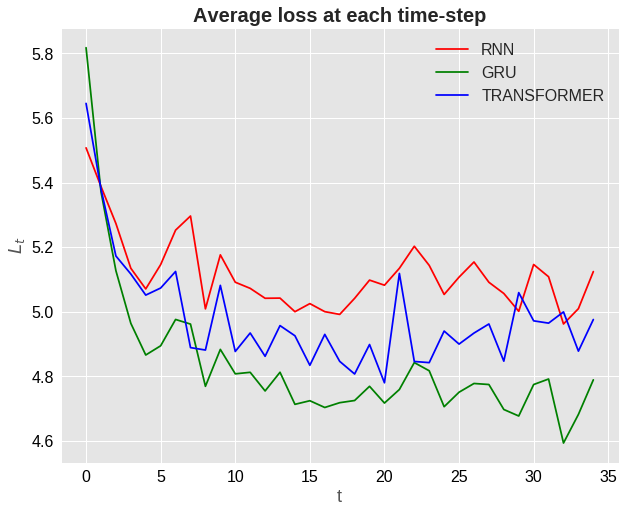

In [61]:
colors = ['red','green','blue']

plt.figure(figsize=(10,8))
for key,value,color in zip(losses.keys(),losses.values(),colors):
  plt.plot(value, label = key, color = color)
plt.xlabel('t')
plt.ylabel('$L_t$')
plt.title('Average loss at each time-step')  
plt.legend()  
plt.show()